Leandro Saraco - Valentin Pertierra

### TP3 Visión por computadora


Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs / images a partir del template Material_TPs / template

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
# Cargo las imagenes a utilizar en el tp
pattern = cv.imread('template/pattern.png')

coca_logo_1 = cv.imread('images/coca_logo_1.png')
coca_logo_2 = cv.imread('images/coca_logo_2.png')
coca_logo_3 = cv.imread('images/COCA-COLA-LOGO.jpg')
coca_logo_4 = cv.imread('images/logo_1.png')
coca_multi = cv.imread('images/coca_multi.png')
coca_retro_1 = cv.imread('images/coca_retro_1.png')
coca_retro_2 = cv.imread('images/coca_retro_2.png')

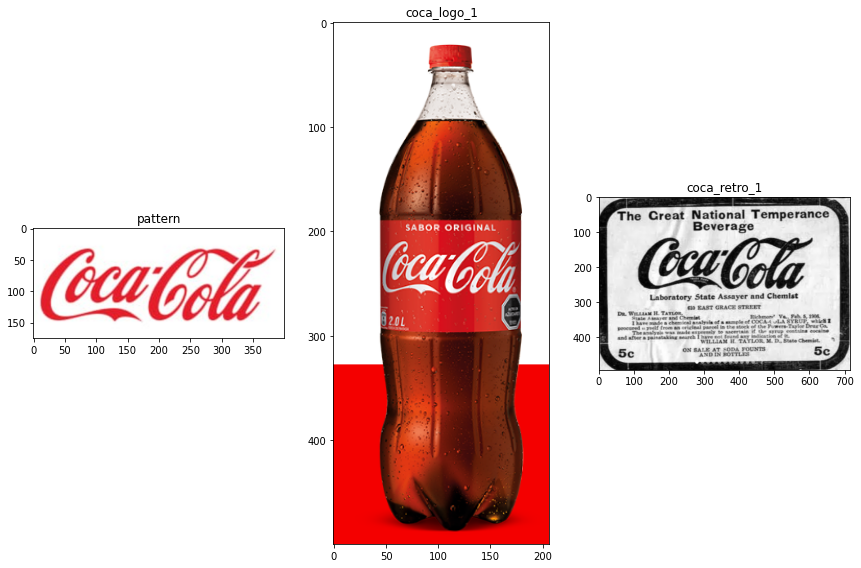

In [3]:
plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title('pattern')
plt.imshow(pattern[:,:,::-1])

plt.subplot(1,3,2)
plt.title('coca_logo_1')
plt.imshow(coca_logo_1[:,:,::-1])

plt.subplot(1,3,3)
plt.title('coca_retro_1')
plt.imshow(coca_retro_1[:,:,::-1])

plt.tight_layout()

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos

In [4]:
# Utilizo template matching para encontrar el patron dentro de la imagen
# Analizo en multiples escalas del patron
def findPattern(pattern, img, n, method=cv.TM_CCOEFF_NORMED):
    
    # Convierto las imagenes a escala de grises
    patternGray = cv.cvtColor(pattern, cv.COLOR_BGR2GRAY) 
    imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
    
    # Obtengo una imagen de bordes para abstraernos del fondo y colores    
    imgGray = cv.Laplacian(cv.GaussianBlur(imgGray,(5,5),0), cv.CV_8U)
    
    ph,pw = patternGray.shape
    ih,iw = imgGray.shape
    
    # Analizo n escalas distintas del patron
    # Utilizo el ancho de la imagen como ancho del patron mas grande
    scales = np.linspace(0, iw/pw, n+1)[1:]
    
    # Guardo los resultados de todas las escalas en una lista
    matching = list()
    minMaxRes = np.zeros((n,8))
    
    for i, scale in enumerate(scales):
        
        # Escalo el patron
        resPattern = cv.resize(patternGray, None, fx=scale, fy=scale)
        
        # Aplico un filtro laplaciano para quedarme con los bordes
        resPattern = cv.Laplacian(cv.GaussianBlur(resPattern,(3,3),0), cv.CV_8U)
        ph,pw = resPattern.shape
        
        # Aplico el template matching 
        res = cv.matchTemplate(imgGray, resPattern, method)
         
        # Hago una estandarizacion para poder hacer una comparacion entre todos los resultados 
        res = (res-np.mean(res))/np.std(res)
        
        # Guardo el resultado
        matching.append(res)

        # Guardo datos de interes para graficar la bounding box 
        minVal, maxVal, minLoc, maxLoc = cv.minMaxLoc(res)
        minMaxRes[i,:] = [minVal, maxVal, minLoc[0], minLoc[1], maxLoc[0], maxLoc[1], ph, pw]
    
    
    # Busco el maximo entre todas las escalas <- se podria generalizar para los metodos que minimizan
    iMax = np.argmax(minMaxRes[:,1])
    loc = minMaxRes[iMax,:]
    
    # Grafico una bounding box donde encontre el maximo
    matchImg = img.copy()
    topLeft = (int(loc[4]),int(loc[5]))
    bottomRight = (int(loc[4]+loc[7]), int(loc[5]+loc[6]))
 
    cv.rectangle(matchImg, topLeft, bottomRight, (0,255,0), 2)    
  
    return matching, minMaxRes, matchImg

In [5]:
# Funcion para graficar las imagenes 
def showImg(img):
    plt.figure(figsize=(8,6))
    plt.imshow(img[:,:,::-1])
    plt.tight_layout()

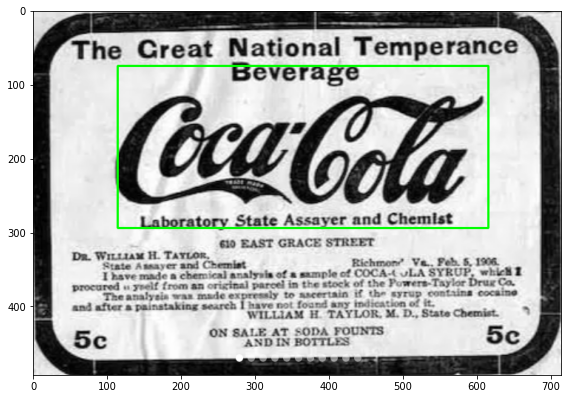

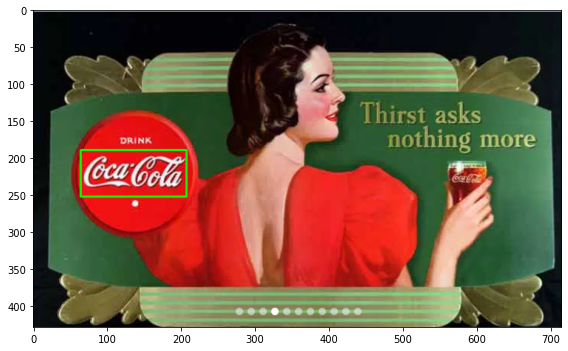

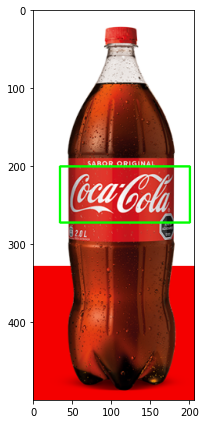

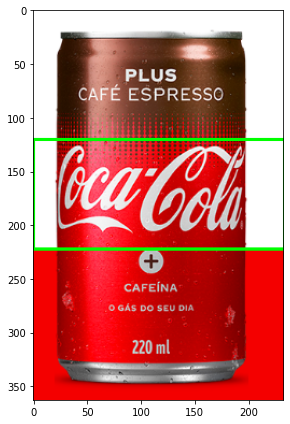

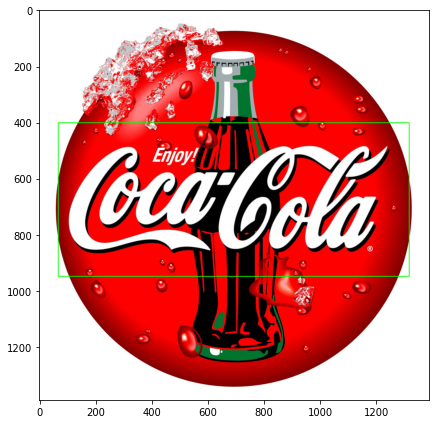

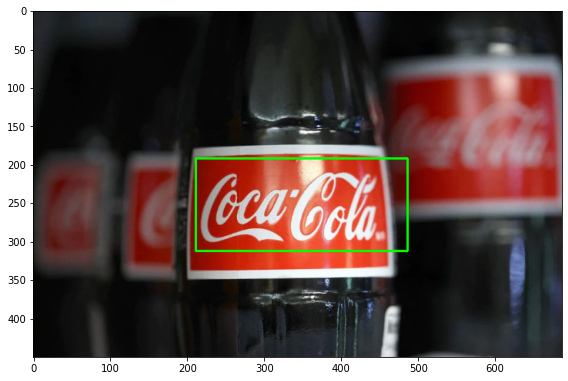

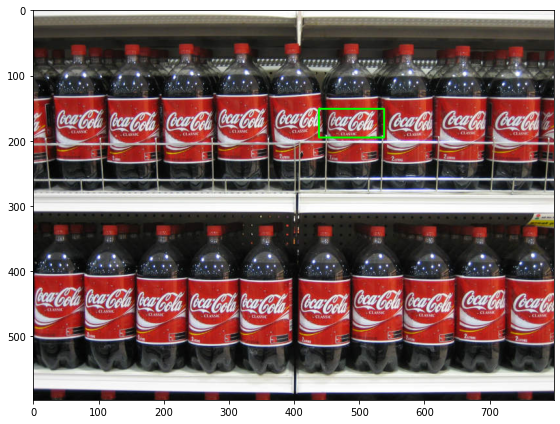

In [6]:
# Aplico la deteccion y grafico los resultados

_, _, res = findPattern(pattern, coca_retro_1, 10)
showImg(res)
_, _, res = findPattern(pattern, coca_retro_2, 10)
showImg(res)
_, _, res = findPattern(pattern, coca_logo_1, 10)
showImg(res)
_, _, res = findPattern(pattern, coca_logo_2, 1)
showImg(res)
_, _, res = findPattern(pattern, coca_logo_3, 10)
showImg(res)
_, _, res = findPattern(pattern, coca_logo_4, 10)
showImg(res)
_, _, res = findPattern(pattern, coca_multi, 40)
showImg(res)

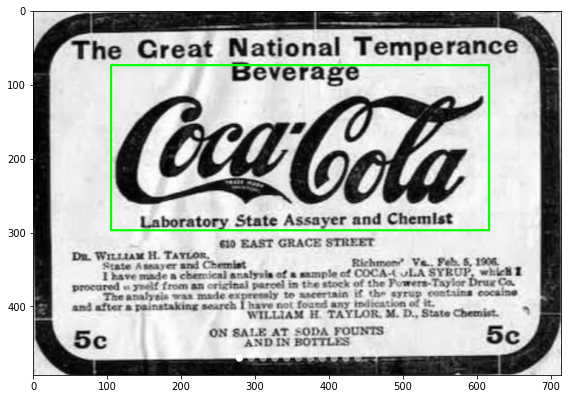

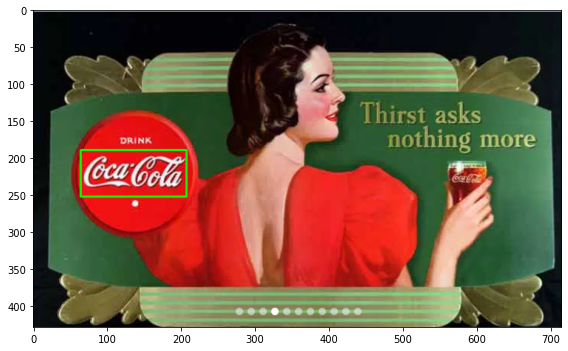

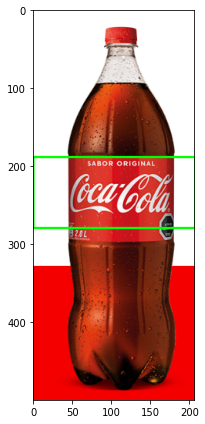

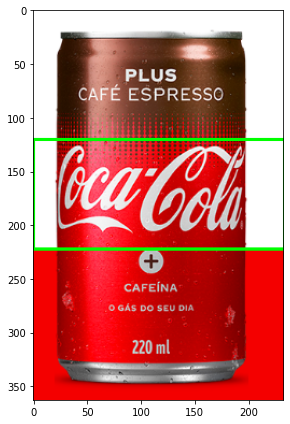

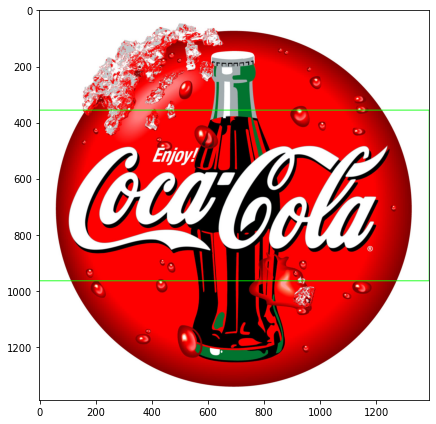

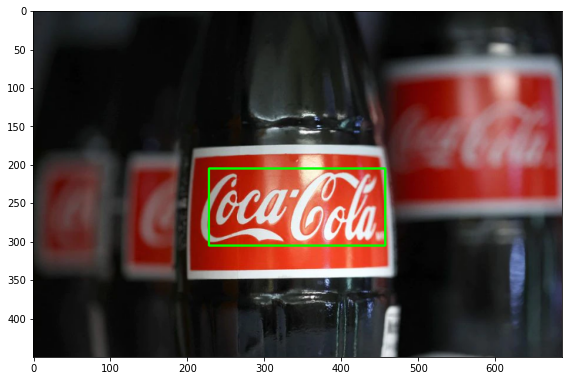

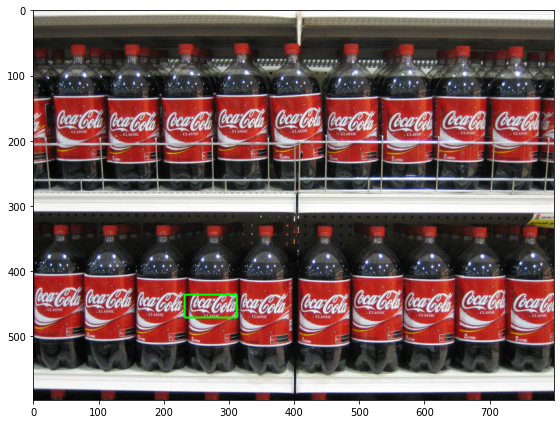

In [7]:
# Pruebo con otro metodo cv.TM_CCORR
_, _, res = findPattern(pattern, coca_retro_1, 7, cv.TM_CCORR)
showImg(res)

_, _, res = findPattern(pattern, coca_retro_2, 5, cv.TM_CCORR)
showImg(res)
_, _, res = findPattern(pattern, coca_logo_1, 1, cv.TM_CCORR)
showImg(res)
_, _, res = findPattern(pattern, coca_logo_2, 1, cv.TM_CCORR)
showImg(res)
_, _, res = findPattern(pattern, coca_logo_3, 1, cv.TM_CCORR)
showImg(res)
_, _, res = findPattern(pattern, coca_logo_4, 3, cv.TM_CCORR)
showImg(res)

_, _, res = findPattern(pattern, coca_multi, 10, cv.TM_CCORR)
showImg(res)



2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi png con el mismo témplate del ítem 1

In [8]:
# Utilizo template matching para encontrar el patron dentro de la imagen
# Analizo en multiples escalas del patron y obtengo multiples detecciones
def findMultiplePattern(pattern, img, n, th, method=cv.TM_CCOEFF_NORMED, nms=False):
    
    # Convierto las imagenes a escala de grises
    patternGray = cv.cvtColor(pattern, cv.COLOR_BGR2GRAY) 
    imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
    
    # Obtengo una imagen de bordes para abstraernos del fondo y colores    
    imgGray = cv.Laplacian(cv.GaussianBlur(imgGray,(5,5),0), cv.CV_8U)
    
    ph,pw = patternGray.shape
    ih,iw = imgGray.shape
    
    # Analizo n escalas distintas del patron
    # Utilizo el ancho de la imagen como ancho del patron mas grande
    scales = np.linspace(0, iw/pw, n+1)[1:]
    
    # Guardo los resultados de todas las escalas en una lista
    matching = list()
    
    # Guardo la ubicacion de los match para luego hacer Non Maximun Suppression
    locRes = list()
    confidenceScores = list()
    
    matchImg = img.copy()
    
    for i, scale in enumerate(scales):
        
        # Escalo el patron
        resPattern = cv.resize(patternGray, None, fx=scale, fy=scale)
        
        # Aplico un filtro laplaciano para quedarme con los bordes
        resPattern = cv.Laplacian(cv.GaussianBlur(resPattern,(3,3),0), cv.CV_8U)
        ph,pw = resPattern.shape
        
        # Aplico el template matching 
        res = cv.matchTemplate(imgGray, resPattern, method)
        
        # Hago una estandarizacion para poder hacer una comparacion entre todos los resultados 
        res = (res-np.mean(res))/np.std(res)
        
        # Guardo el resultado
        matching.append(res)
        
        # Si el valor maximo supera un umbral th la considero como un match
        # Guardo datos de interes para graficar las bounding box
        # Guaro coordenadas [x0, y0, x1, y1]
        loc = np.where(res >= th)
        for pt in zip(*loc[::-1]): 
            
            locRes.append([pt[0], pt[1], pt[0]+pw, pt[1]+ph])
            
            # Obtengo una metrica del nivel de confianza de la deteccion
            value = res[pt[::-1]]
            confidenceScores.append(value/np.max(res))
            
    # Utilizo un algoritmo de Non Maximun Suppression (NMSBoxes) para eliminar las bounding box que se solapan
    if nms:
        indices = cv.dnn.NMSBoxes(bboxes=locRes, scores=confidenceScores, score_threshold=0.75, nms_threshold=0.75)
        for i in indices:
            coord = locRes[i]
            
            cv.rectangle(matchImg, (coord[0],coord[1]), (coord[2], coord[3]), (0,255,0), 2)
            
            # La metrica de confianza es medio chamuyo, esta armada para que funcione nms, pero supongo debe haber alguna metrica mejor 
            cv.putText(matchImg,f'coca {str(int(confidenceScores[i]*100))}%', (coord[0],coord[1]-4), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 1, cv.LINE_AA)
    else:
        for coord in locRes:
            cv.rectangle(matchImg, (coord[0],coord[1]), (coord[2], coord[3]), (0,255,0), 2)
    
    return matching,  matchImg

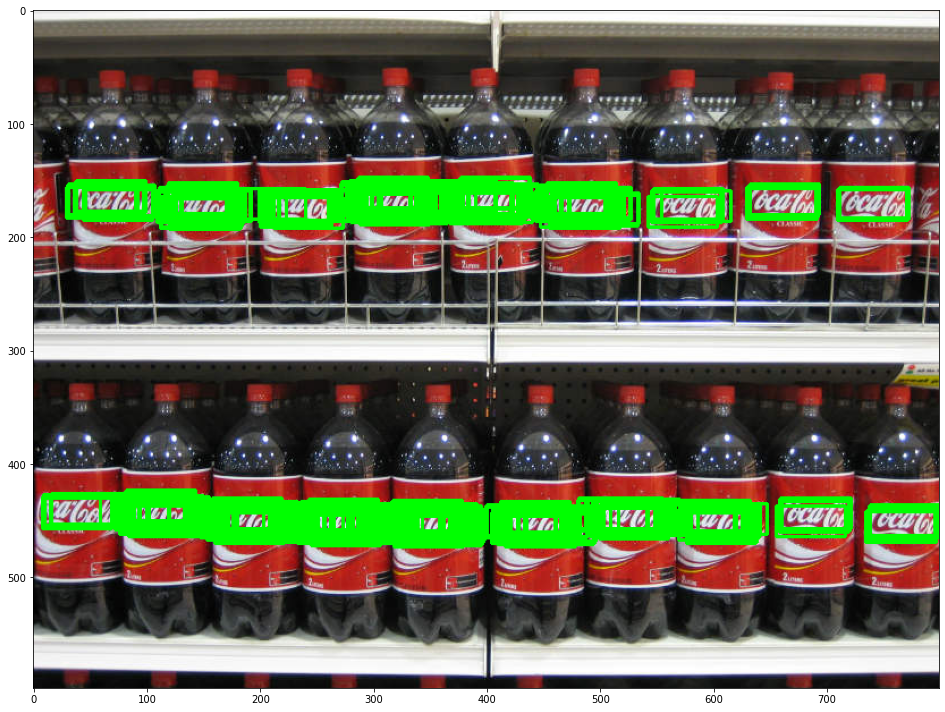

In [9]:

_, res = findMultiplePattern(pattern, coca_multi, 13, 3.5, cv.TM_CCORR)

plt.figure(figsize=(16,10))
plt.imshow(res[:,:,::-1])
plt.tight_layout()

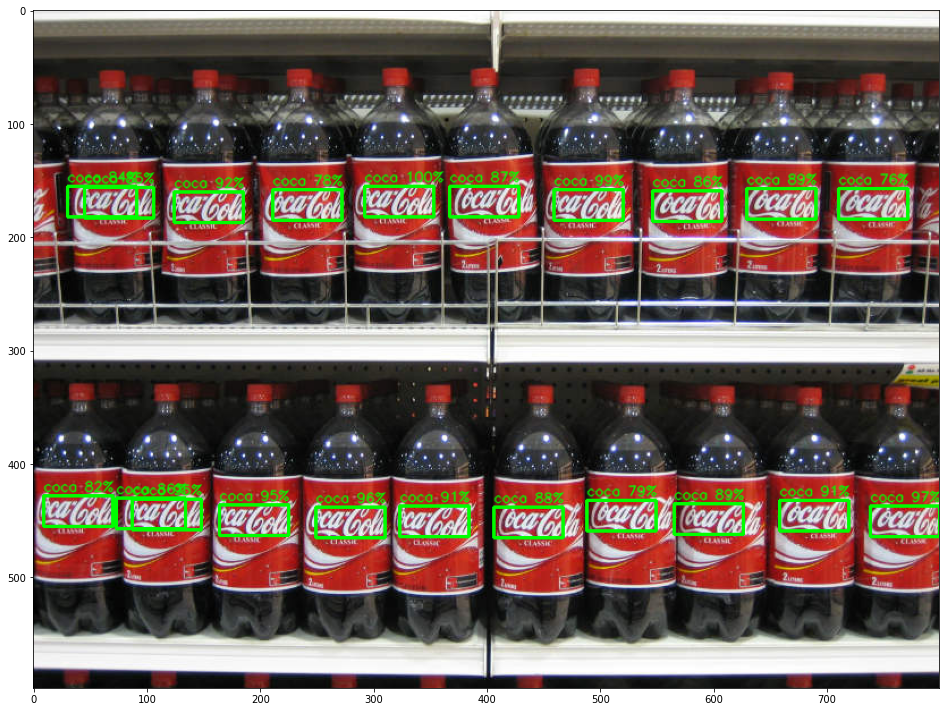

In [44]:
# En este punto tendria que mejorar el algoritmo de NMS, tal vez ajustando mejor los umbrales o calculando otra metrica para la confianza de la deteccion 
_, res = findMultiplePattern(pattern, coca_multi, 13, 3.5, cv.TM_CCORR, True)

plt.figure(figsize=(16,10))
plt.imshow(res[:,:,::-1])
plt.tight_layout()

3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes

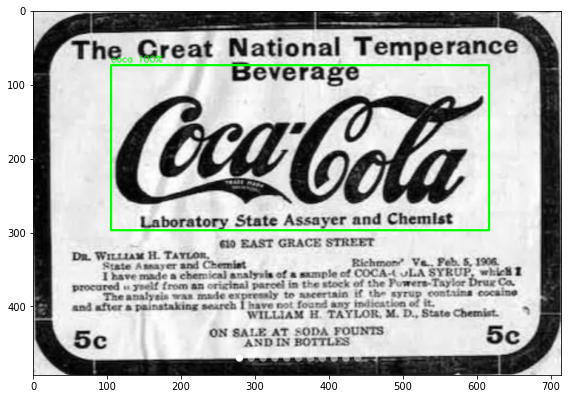

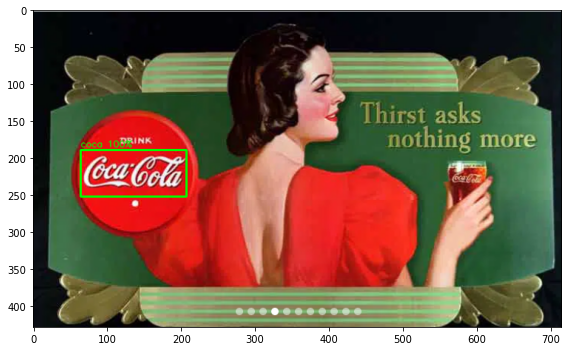

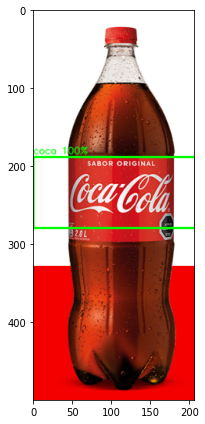

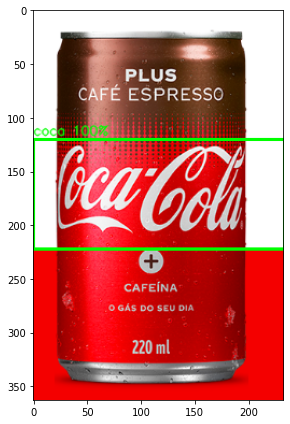

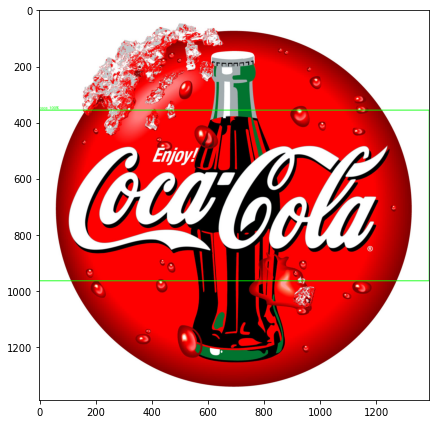

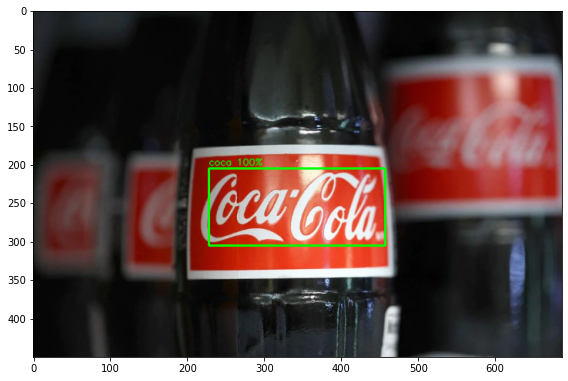

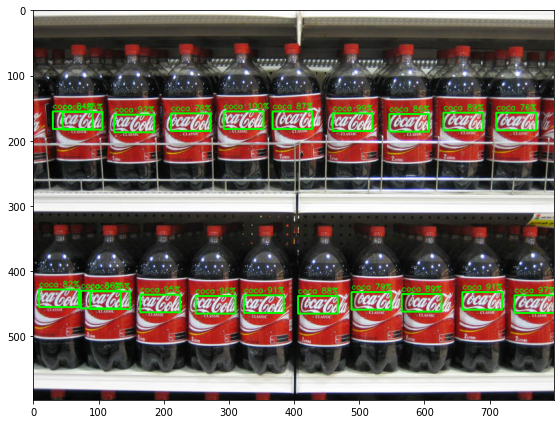

In [43]:
_, res = findMultiplePattern(pattern, coca_retro_1, 7, 4, cv.TM_CCORR, True)
showImg(res)

_, res = findMultiplePattern(pattern, coca_retro_2, 5, 7, cv.TM_CCORR, True)
showImg(res)

_, res = findMultiplePattern(pattern, coca_logo_1, 1, 1, cv.TM_CCORR, True)
showImg(res)

_,res = findMultiplePattern(pattern, coca_logo_2, 1, 1, cv.TM_CCORR, True)
showImg(res)

_,res = findMultiplePattern(pattern, coca_logo_3, 1, 1, cv.TM_CCORR, True)
showImg(res)

_, res = findMultiplePattern(pattern, coca_logo_4, 3, 3.5, cv.TM_CCORR, True)
showImg(res)

_, res = findMultiplePattern(pattern, coca_multi, 13, 3.5, cv.TM_CCORR, True)
showImg(res)
